# GC Data Collection and Elaboration

In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import re
import matplotlib.pyplot as plt
import xlsxwriter
import tkinter as tk
from tkinter import filedialog

## Data from User
The following cell contains the data which are collected and elaborated by the user.

In [2]:
#Type of test
Current_Density = [-50, -50, -100, -100, -150, -150, -200, -200, -250, -250, -300, -300]

#From CO2 calibration curve
value_a = -257051.28935
value_b = -4313.06376

#Gases calibration curves and DataFrame creation
data = {
    'n': [2, 2, 8, 12],
    #from calibration curve y = mx + c
    'c': [814.35, 152.05, 1.1672, 102.27], 
    'm': [12739.3671, 11343, 1590.4, 1843.5],
    #Faraday constant
    'F': [96485.3329, 96485.3329, 96485.3329, 96485.3329],
    #Molar volume
    'k': [24465.3953, 24465.3953, 24465.3953, 24465.3953]
}
calibration = pd.DataFrame(data, index=['H2', 'CO', 'CH4', 'C2H4'])
calibration = calibration.transpose()
calibration

,H2,CO,CH4,C2H4
n,2.0000,2.0000,8.0000,12.0000
c,814.3500,152.0500,1.1672,102.2700
m,12739.3671,11343.0000,1590.4000,1843.5000
F,96485.3329,96485.3329,96485.3329,96485.3329
k,24465.3953,24465.3953,24465.3953,24465.3953


## Import files
The following code allows the user to import .XLS files which are named with date and time encoding. Check the `pattern` variable prior using the notebook.

In [3]:
#Set the current directory for the kernel
#path = os.getcwd()
#files = os.listdir(path)
#files_xls = [f for f in files if f[-3:] == 'XLS']

def select_folder():
    root = tk.Tk()
    root.withdraw()
    folder_path = filedialog.askdirectory()
    return folder_path

# Select the folder interactively
folder_path = select_folder()

# List all XLS files in the selected folder
files = os.listdir(folder_path)
files_xls = [f for f in files if f[-3:] == 'XLS']


#Set the file name pattern to sort the name through the code by date and time rather than sample number
pattern = r'\d{2}_\d{2}_\d{4}\s\d{2}_\d{2}_\d{2}'
filename_datetime_list = []
for filename in files_xls:
    match = re.search(pattern, filename)
    if match:
        datetime_str = match.group()
        datetime_obj = datetime.datetime.strptime(datetime_str, "%d_%m_%Y %H_%M_%S")
        filename_datetime_list.append((filename, datetime_obj))

# Sort the list of tuples based on the datetime object
sorted_filename_datetime_list = sorted(filename_datetime_list, key=lambda x: x[1])
sorted_filenames = [x[0] for x in sorted_filename_datetime_list]

#This part of the code creates a full DataFrame which contains all the data from every excel file by keeping 
#the data sorted by worksheet
dfs = []
for filename in sorted_filenames:
    dfname = pd.ExcelFile(os.path.join(folder_path, filename))
    for items in dfname.sheet_names:
        dfnew = pd.read_excel(dfname, sheet_name=items)
        dfnew['filename'] = filename  # add a new column to identify the source file
        dfs.append(dfnew)
data = pd.concat(dfs, ignore_index=True)

#This part of the script rearranges the data according to the filename and keeps only the information about the 
#second occurrance of Nitrogen, which is the one needed
a = ['Hydrogen', 'Carbon monoxide', 'Nitrogen', 'Methane', 'Ethylene']
data = data.groupby('filename',as_index=False, sort=False).apply(lambda x: x[x['Name'].isin(a)].drop_duplicates(subset='Name', keep='last'))
data = data[['Name', 'Area', 'filename']].reset_index(drop=True)

#Dealing with non-numerical data, such as N.D.=not detected from the instrument
data["Area"] = data["Area"].replace(["N.D."], 0)
data["Area"] = pd.to_numeric(data["Area"])

#Target table generation
pivot_table = data.pivot_table(index='filename', columns='Name', values='Area', sort=False)
column_order = ['Hydrogen', 'Carbon monoxide', 'Nitrogen', 'Methane',  'Ethylene']
pivot_table = pivot_table.reindex(columns=column_order)

## Data Elaboration
The following cell contains all the steps and functions to calculate the Faraday Efficiencies of the process as function of current density. Step by step:
1. The current densities are fixed by the user
2. From the CO<sub>2</sub> calibration curve it is possible to calculate the CO<sub>2</sub> flowrate
3. Calculation of partial current densities (j<sub>product</sub>):
$$
j_{product} = \frac{n * C * Q_{flow} * F}{V_m}
$$

Where _n_ is the number of transferred electrons, _C_ is the concentration of gaseous product, _Q<sub>flow</sub>_ is the volumetric flowrate (mL/min) and _V<sub>m</sub>_ is the molar volume of gas (mL/mol). The values were obtained from the standard calibration curves of each component of the product mixture.

4. Calculation of Faraday efficiencies from partial current densities divided by the total current density

In [4]:
#Add a new column to the pivot_table which contains the current densities (mAcm-2)
length_diff = len(Current_Density) - len(pivot_table)
if length_diff > 0:
    pivot_table = pd.concat([pivot_table, pd.DataFrame(np.nan, index=np.arange(length_diff), columns=pivot_table.columns)], axis=0)
pivot_table['Current Density (mAcm-2)'] = Current_Density

#Remove the rows which contains NaN values.
pivot_table = pivot_table.dropna()

#Rename the columns
pivot_table = pivot_table.rename(columns={'Hydrogen': 'H2', 'Carbon monoxide': 'CO', 'Nitrogen': 'N2', 'Methane': 'CH4', 'Ethylene': 'C2H4'})

#TO BE MODIFIED BY THE USER WHEN THE CO2 CALIBRATION CURVE IS REPEATED
#Add a column with a formula to obtain the CO2 flow rate (mL/min) from CO2 calibration curve (user)
pivot_table['CO2 flow rate (mL/min)'] = (pivot_table['N2'] + value_a) / value_b

#Since both 'calibration' and 'pivot_table' dataframe are based on the same chemical compounds, the following mathematical function is based on their column names
#to keep it general. N2 is not a target compound, it is just a carrier during the tests.

col_names = ['H2', 'CO', 'CH4', 'C2H4']
for col in col_names:
    pivot_table[f'J ({col}) (mAcm-2)'] = (calibration.loc['n', col]) * ((pivot_table[col] - calibration.loc['c', col]) / (calibration.loc['m', col] * 100)) * (calibration.loc['F', col] / calibration.loc['k', col]) * ((pivot_table['CO2 flow rate (mL/min)'] / 60) * (1000 / 10))

#Faraday Efficiencies (FE) are calculated by dividing the partial current densities by the total current density

cur_den_name = ['J (H2) (mAcm-2)', 'J (CO) (mAcm-2)', 'J (CH4) (mAcm-2)', 'J (C2H4) (mAcm-2)']
for col_name, col in zip(col_names, cur_den_name):
        pivot_table[f'FE ({col_name}) (%)'] = np.abs((pivot_table[col] / pivot_table['Current Density (mAcm-2)'])) * 100

#pivot_table.to_excel("GC_outputs.xlsx")
#pivot_table

## Graph builder
Plot FE (%) vs J<sub>tot</sub> and create a DataFrame with the data table.

Excel file and plot saved to: C:/Users/GadolS01/OneDrive - Johnson Matthey/CATART/Python Scripts/230418 EF-1-11_Galvanostatic


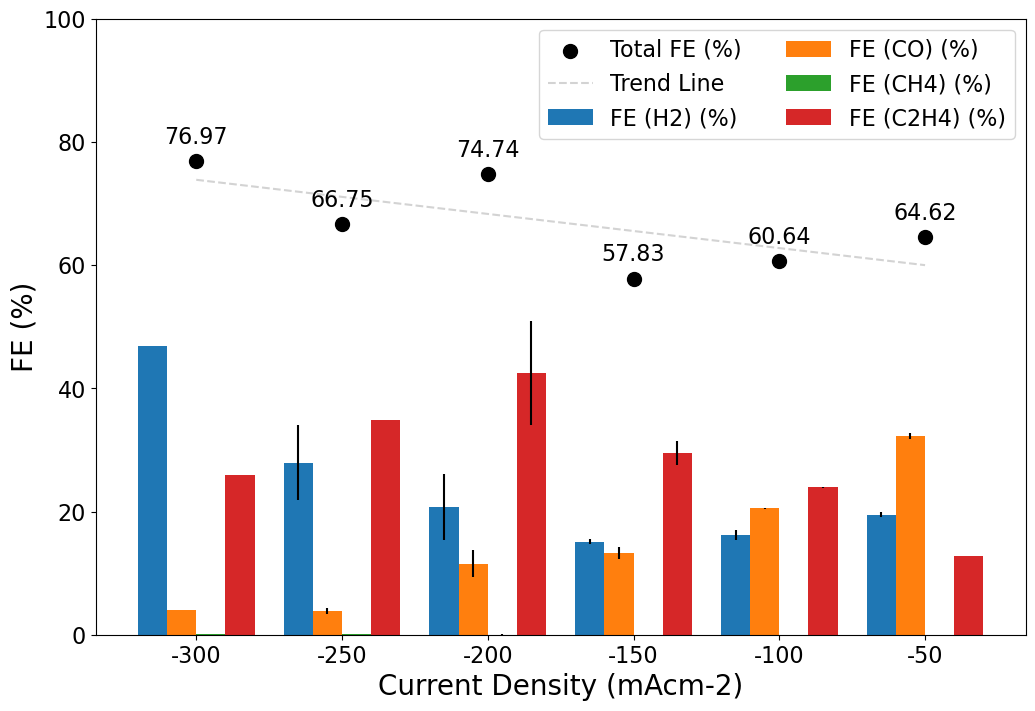

,FE (H2) (%),FE (CO) (%),FE (CH4) (%),FE (C2H4) (%),FE (H2) (%) (SE),FE (CO) (%) (SE),FE (CH4) (%) (SE),FE (C2H4) (%) (SE),Total FE (%)
Current Density (mAcm-2),,,,,,,,,
-300.00,46.829457,3.974759,0.178671,25.989357,NaN,NaN,NaN,NaN,76.972245
-250.00,27.910029,3.878960,0.071935,34.887657,6.058076,0.460189,0.001669,0.008052,66.748580
-200.00,20.772452,11.491852,0.033391,42.439558,5.396556,2.188829,0.006555,8.426127,74.737253
-150.00,15.090829,13.240060,0.011396,29.483644,0.435196,0.977166,0.001319,1.931265,57.825929
-100.00,16.196721,20.503667,0.013797,23.926350,0.829060,0.137821,0.001893,0.094696,60.640535
-50.00,19.514403,32.267238,0.024952,12.812901,0.373798,0.468311,0.000833,0.036305,64.619494


In [10]:
#For every current density's value, the following code will plot four columns related to the FEs (%) for the compounds of the final mix.
#Add the error bars calculated from standard deviation. Experimental background: the measurments are repeated twice to monitor the reproducibility and error.

#Extract the unique values of 'Current Density (mAcm-2)'
x = np.unique(pivot_table['Current Density (mAcm-2)'])

#Define the column labels
columns = ['FE (H2) (%)', 'FE (CO) (%)', 'FE (CH4) (%)', 'FE (C2H4) (%)']

#Calculate the mean and standard error for each column
mean_values = pivot_table.groupby('Current Density (mAcm-2)')[columns].mean()
std_error_values = pivot_table.groupby('Current Density (mAcm-2)')[columns].sem()

#Calculate the total 'FE (%)' for each 'Current Density (mAcm-2)' value
total_values = mean_values.sum(axis=1)

#Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

#Calculate the width for each group of columns
width = 10

#Plot each group of columns
for i, col in enumerate(columns):
    x_pos = x + (i - (len(columns) - 1) / 2) * width
    y = mean_values[col]
    y_err = std_error_values[col]
    ax.bar(x_pos, y, width, yerr=y_err, label=col)

#Plot the total 'FE (%)' as scatter plot markers
ax.scatter(x, total_values, s=100, marker='o', color='black', label='Total FE (%)')  # Adjust marker size and color as desired

#Fit a polynomial regression line to the total 'FE (%)' values
fit_coeffs = np.polyfit(x, total_values, deg=1)
trend_line = np.poly1d(fit_coeffs)
ax.plot(x, trend_line(x), linestyle='--', color='lightgrey', label='Trend Line')

#Set the x and y labels
ax.set_xlabel('Current Density (mAcm-2)', fontsize=20)
ax.set_ylabel('FE (%)', fontsize=20)
ax.tick_params(axis='both', labelsize=16)

#Set the y-axis limits
ax.set_ylim(0, 100)

#Set the x-axis ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(x)

#Set the legend position
legend=ax.legend(loc='best', fontsize=16, ncol=2)
#Set the background color of the legend
legend.get_frame().set_facecolor('white')

#Show the grid
#ax.grid(True)

#Add label to the total 'FE (%)' scatter plot
for i, j in zip(x, total_values):
    ax.text(i, j + 2, f'{j:.2f}', ha='center', va='bottom', fontsize=16)

#Concatenate mean_values and std_error_values into a single table
table_data = np.concatenate((mean_values, std_error_values, total_values.to_frame(name='Total FE (%)')), axis=1)
row_labels = [f'{val:.2f}' for val in x]
column_labels = columns + [f'{col} (SE)' for col in columns] + ['Total FE (%)']

#Create a DataFrame from the table data
table_df = pd.DataFrame(table_data, index=row_labels, columns=column_labels)

#Rename the index name to 'Current Density (mAcm-2)'
table_df = table_df.rename_axis('Current Density (mAcm-2)')

#Select the folder interactively
output_folder = folder_path

#Set the file paths for output
output_excel_path = os.path.join(output_folder, 'output.xlsx')
output_plot_path = os.path.join(output_folder, 'plot.jpeg')

#Example code to save the output
with pd.ExcelWriter(output_excel_path, engine='xlsxwriter') as writer:
    #Write the pivot_table DataFrame to Excel
    pivot_table.to_excel(writer, sheet_name='Data Analysis')

    #Create a new worksheet for the plot
    worksheet_plot = writer.book.add_worksheet('Plot')

    #Save the plot as an image
    plt.savefig(output_plot_path, bbox_inches='tight')

    #Insert the plot image into the worksheet
    worksheet_plot.insert_image('B2', output_plot_path)

    #Write the table_df DataFrame to Excel
    table_df.to_excel(writer, sheet_name='FE (%)')

print(f"Excel file and plot saved to: {output_folder}")

#Show the plot
plt.show()

#Display the table
table_df

## GSTAT Data visualisation

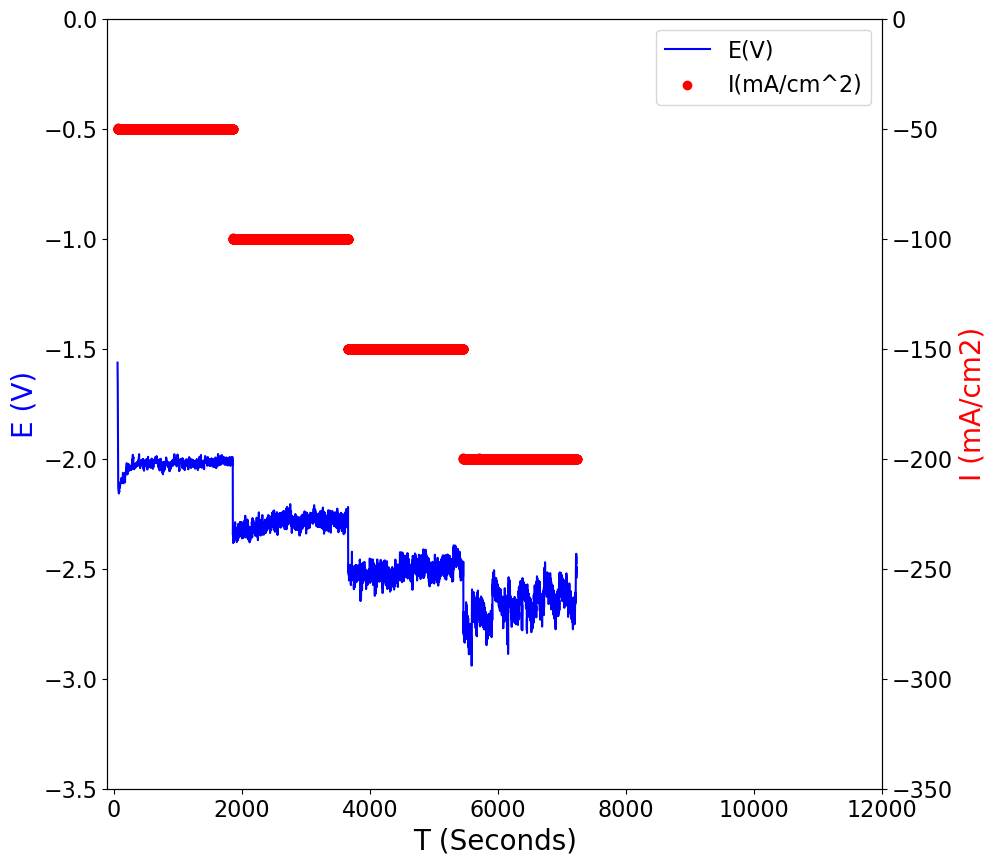

In [7]:
#Import the file
directory_path = folder_path
file_gstat = '/GSTAT_ALL.txt'
file_path = directory_path + file_gstat
gstat = pd.read_csv(file_path, delimiter='\t')

#Convert the Current 'I(A)' into 'I (mA/cm2)'
gstat['I(A/cm2)'] = gstat['I(A/cm2)'] * (1000 / 10)
gstat = gstat.rename(columns={'I(A/cm2)': 'I(mA/cm2)'})

# Extract the columns for the plot
x = gstat['T(Seconds)']
y1 = gstat['E(V)']
y2 = gstat['I(mA/cm2)']

# Create the figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 10))

# Plot the first y-axis (E(V))
line1 = ax1.plot(x, y1, color='blue', label='E(V)')
ax1.set_xlabel('T (Seconds)', fontsize=20)
ax1.set_ylabel('E (V)', color='blue', fontsize=20)
ax1.set_ylim(-3.5, 0)
ax1.set_xlim(-100, 12000)
ax1.tick_params(axis='both', labelsize=16)

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the second y-axis (I(mA/cm^2))
line2 = ax2.scatter(x, y2, color='red', label='I(mA/cm^2)')
ax2.scatter(x, y2, color='red')
ax2.set_ylabel('I (mA/cm2)', color='red', fontsize=20)
ax2.set_ylim(-350, 0)
ax2.tick_params(axis='both', labelsize=16)

# Set the legend
lines = line1 + [line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='best', fontsize=16)

# Display the plot
plt.show()
